In [1]:
import sys
# setting path
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage.filters import gaussian_filter

from src import io, var, utils, fourier, lin_reg, reconstruction, physics, delaunay
from vis import plotter, cart_plot

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
importlib.reload(delaunay)

importlib.reload(plotter)
importlib.reload(cart_plot)

<module 'vis.cart_plot' from '/home/ray/git-projects/spec_appx/notebooks/../vis/cart_plot.py'>

Setup objects and read data. Specify the extent of the lat-lon grid to be read in.

Data fetched...


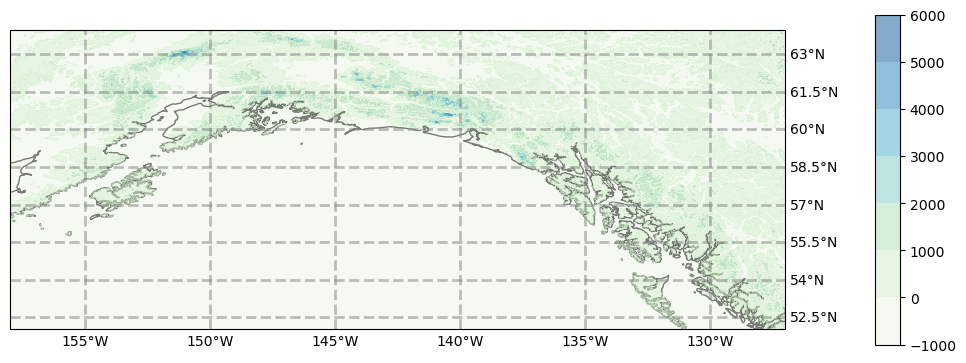

In [3]:
# initialise data objects
grid = var.grid()
topo = var.topo_cell()

# read grid
reader = io.ncdata()
fn = '../data/icon_compact.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg) 

# read topography
fn = '../data/topo_compact.nc'
reader.read_dat(fn, topo)

# we only keep the topography that is inside this lat-lon extent.
lat_verts = np.array([52.,64.,64.])
lon_verts = np.array([-141.,-158.,-127.])

reader.read_topo(topo, topo, lon_verts, lat_verts)

topo.gen_mgrids()

# Plot the loaded topography...
cart_plot.lat_lon(topo)

In [4]:
print(topo.lat.min())
print(topo.lat.max() - topo.lat.min())

print(topo.lon.min())
print(topo.lon.max() - topo.lon.min())

print("")
print(len(topo.lat)/len(topo.lon))


print(topo.lon)
# topo.lon = utils.latlon2m(topo.lon, topo.lat[0], latlon='lon')
# topo.lat = utils.latlon2m(topo.lat, topo.lon[0], latlon='lat')

# topo.gen_mgrids()

52.00416564941406
11.991668701171875
-157.99583435058594
30.991668701171875

0.3870967741935484
[-157.99583435 -157.98750305 -157.97917175 ... -127.02083588 -127.01249695
 -127.00416565]


Plot the Delaunay triangular, its vertices, and the computed centroids against the background of the topography.

Delaunay triangulation object created.
Number of triangles = 882
rect_set =  [ 88 112 126 262 320 392 714 732 784]


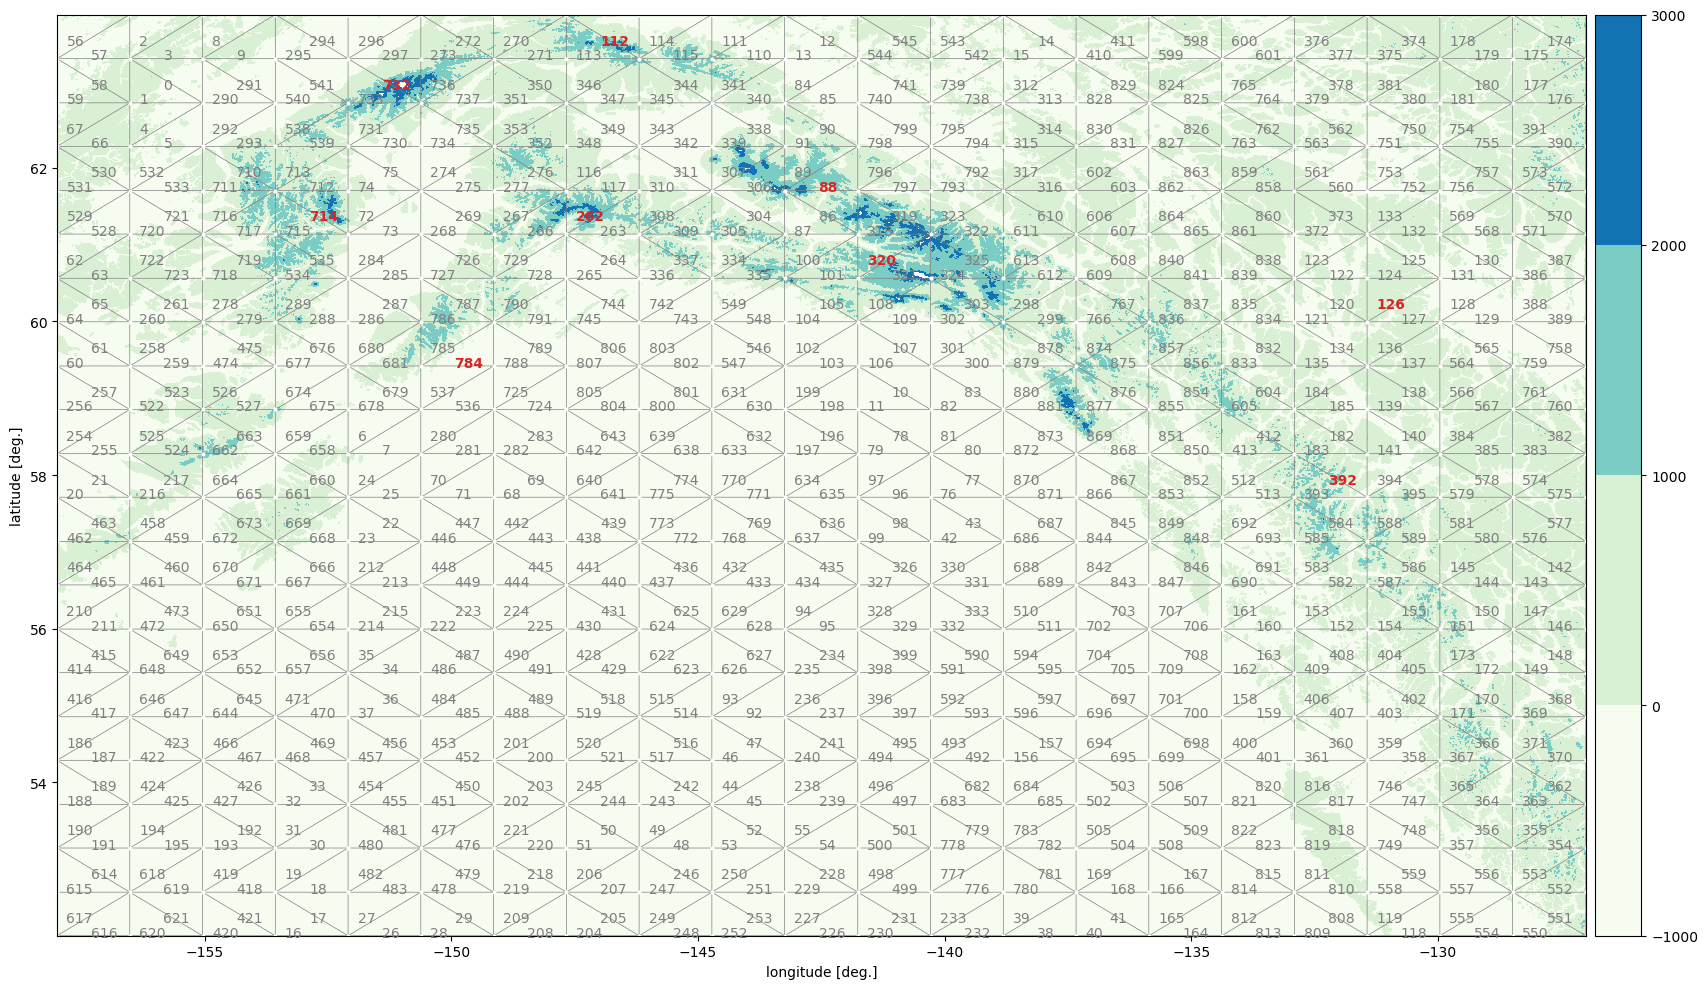

In [5]:
# Setup Delaunay triangulation domain.
tri = delaunay.get_decomposition(topo, xnp=22, ynp=22)
# tri = delaunay.get_decomposition(topo, xnp=16, ynp=11)

#11x6
# rect_set = np.sort([0,4,54,92,52,16,44,48,88,58,94])

#11x11
# rect_set = np.sort([20,26,4,74,130,168,180,102,40,112])
# rect_set = np.array([102])

#16x11
# rect_set = np.sort([156,154,32,72,68,160,96,162,276,60])
# rect_set = np.array([72])

#22x22
rect_set = np.sort([88,320,126,392,714,262,732,784,112])
# rect_set = np.array([392])
print("rect_set = ", rect_set)

levels = np.linspace(-1000.0, 3000.0, 5)
cart_plot.lat_lon_delaunay(topo, tri, levels, label_idxs=True, fs=(20,10), highlight_indices=rect_set)

In [6]:
np.random.seed(288)

r_row = np.random.randint(0,144-5,size=10)
r_col = np.random.randint(0,144-5-1,size=10)
r_entries = np.random.randint(0,((144-5)*2)-1,size=10)
r_ampl = np.random.random(size=10)

sz = 10
nk = np.random.randint(0,12, size=sz)
nl = np.random.randint(-5,6, size=sz)

for ii  in range(sz):
    if nk[ii] == 0 and nl[ii] < 0:
        nk[ii] += np.random.randint(1,11)
pts = [item for item in zip(nk,nl)]

pts = np.array(list(set(pts)))

nk = pts[:,0]
nl = pts[:,1]

sz = len(pts)

Ak = np.random.random(size=sz) * 100.0
Al = np.random.random(size=sz) * 100.0

sck = np.random.randint(0,2,size=sz)
scl = np.random.randint(0,2,size=sz)

nhi = 12
nhj = 12
freqs_ref = np.zeros((nhi,nhj))

cnt = 0
for pt in pts:
    kk, ll = pt
    ll += 5
    freqs_ref[ll, kk] = Ak[cnt]
            
    cnt += 1
    
ref_sum = freqs_ref.sum()

def sinusoidal_basis(cell):
    sz = 10
    nk = np.random.randint(0,12, size=sz)
    nl = np.random.randint(-5,6, size=sz)

    for ii  in range(sz):
        if nk[ii] == 0 and nl[ii] < 0:
            nk[ii] += np.random.randint(1,11)
    pts = [item for item in zip(nk,nl)]

    pts = np.array(list(set(pts)))

    nk = pts[:,0]
    nl = pts[:,1]

    sz = len(pts)

    Ak = np.random.random(size=sz) * 100.0
    Al = np.random.random(size=sz) * 100.0
    
    sck = np.random.randint(0,2,size=sz)
    scl = np.random.randint(0,2,size=sz)
    
    for ii in range(sz):
        Akii = Ak[ii]
        nkii = nk[ii]
        nlii = nl[ii]
        sc = sck[ii]
    
        if sc == 0:
            bf = Akii * np.cos(nkii * cell.lon_grid + nlii * cell.lat_grid)
        else:
            bf = Akii * np.sin(nkii * cell.lon_grid + nlii * cell.lat_grid)
            
        cell.topo += bf

    return cell.topo

# Now we do the main looping.

In [10]:
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
importlib.reload(plotter)
# Setup the Fourier parameters and object.
nhi = 24
nhj = 24

U, V = 10.0, 0.1
AE = 6373.0 * 1E3

debug = False
debug_first_guess = False
dfft_first_guess = False
plot = False
verbose = False

pmf_diff = []
pmf_sum_diff = []
idx_name = []

for rect_idx in rect_set:
    all_cells = np.zeros(2, dtype='object')
    iter_cnt = 0
    n_modes = 50
    n_change = -np.inf
    errs = []
    success = False
    while not success:
        for cnt, idx in enumerate(range(rect_idx,rect_idx+2)):
            # initialise cell object
            cell = var.topo_cell()

            print("computing idx:", idx)

            simplex_lat = tri.tri_lat_verts[idx]
            simplex_lon = tri.tri_lon_verts[idx]

            triangle = utils.triangle(simplex_lon, simplex_lat)
            utils.get_lat_lon_segments(tri.tri_lat_verts[idx], tri.tri_lon_verts[idx], cell, topo, triangle, rect=True)

            if dfft_first_guess:
                nhi = len(cell.lon)
                nhj = len(cell.lat)
            fobj = fourier.f_trans(nhi,nhj)
            fobj_tri = fourier.f_trans(nhi,nhj)

 
            #######################################################
            # do we run idealised? 
            
#             if ((cnt == 0)):
#                 cell.topo[...] = 0.0
#                 cell.topo = sinusoidal_basis(cell)
#                 tmp = np.copy(cell.topo)
#                 # cell.mask[...] = True
#                 cell.get_masked(triangle, mask=cell.mask)

#             elif ((cnt == 1)):
#                 cell.topo = tmp
#                 # cell.mask[...] = True
#                 cell.get_masked(triangle, mask=cell.mask)

            #######################################################
    
            if debug:
                print("cell.topo: ", cell.topo.min(), cell.topo.max())
                print("cell.lon: ", cell.lon.min(), cell.lon.max())
                print("cell.lat: ", cell.lat.min(), cell.lat.max())

            mask_tmp = np.copy(cell.mask)

            #######################################################
            # do fourier...

            if not dfft_first_guess:
                fobj.do_full(cell)
                am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.0)

                if debug: print("data_recons: ", data_recons.min(), data_recons.max())

                dat_2D = reconstruction.recon_2D(data_recons, cell)

                if debug: print("dat_2D: ", dat_2D.min(), dat_2D.max())

                fobj.get_freq_grid(am)
                freqs = np.abs(fobj.ampls)

                analysis = var.analysis()
                analysis.get_attrs(fobj, freqs)

                ideal = physics.ideal_pmf(U=U, V=V)

                uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)

                print("uw_pmf_freqs_sum:", uw_pmf_freqs.sum())

            #######################################################
            # do fourier using DFFT

            if dfft_first_guess:
                ampls = np.fft.rfft2(cell.topo - cell.topo.mean())
                ampls /= ampls.size

                freqs = ampls

                wlat = np.diff(cell.lat).max()
                wlon = np.diff(cell.lon).max()

                sz = cell.topo.size

                kks = np.fft.rfftfreq((ampls.shape[1] * 2) - 1, d=1.0)
                # lls = np.fft.fftfreq((ampls.shape[0]), d=1.0)
                lls = np.fft.rfftfreq((ampls.shape[0] * 2) - 1, d=1.0)

                # ampls = np.fft.fftshift(ampls)
                # kks = np.fft.fftshift(kks)
                # lls = np.fft.fftshift(lls)

                kkg, llg = np.meshgrid(kks, lls)

                dat_2D = np.fft.irfft2((ampls) * ampls.size).real 
                ampls = np.abs(ampls)

                if verbose: print(np.sort(ampls.reshape(-1,))[::-1][:25])

                analysis = var.analysis()
                analysis.wlat = wlat
                analysis.wlon = wlon
                analysis.ampls = ampls
                analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
                analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

                ideal = physics.ideal_pmf(U=U, V=V)
                uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)

                print("uw_pmf_freqs_sum:", uw_pmf_freqs.sum())

            #######################################################

            if cnt == 0:
                v_extent = [dat_2D.min(), dat_2D.max()]

            if plot:
                fs = (15.0,5.0)
                fig, axs = plt.subplots(1,3, figsize=fs)
                fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
                axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)

                if dfft_first_guess:
                    axs[1] = fig_obj.fft_freq_panel(axs[1], freqs, kks, lls, typ='real')
                    axs[2] = fig_obj.fft_freq_panel(axs[2], uw_pmf_freqs, kks, lls, title="PMF spectrum", typ='real')
                else:
                    axs[1] = fig_obj.freq_panel(axs[1], freqs)
                    axs[2] = fig_obj.freq_panel(axs[2], uw_pmf_freqs, title="PMF spectrum")
                    
                plt.tight_layout()
                plt.savefig('output/T%i.pdf' %idx)
                plt.show()


            ##############################################
            # debug: compute amplitudes of the first guess
            if debug_first_guess:
                ampls = np.fft.rfft2(cell.topo) 
                ampls /= ampls.size
                ampls = np.abs(ampls)

                ref_power = ampls.sum()

                print("ampls first guess:")
                print(np.sort(ampls.reshape(-1,))[::-1][:25])

                wlat = np.diff(cell.lat).max()
                wlon = np.diff(cell.lon).max()

                sz = cell.topo.size

                # kks = np.fft.fftfreq(cell.topo.shape[1])
                # lls = np.fft.fftfreq(cell.topo.shape[0])

                kks = np.fft.rfftfreq((ampls.shape[1] * 2) - 1, d=1.0).reshape(-1,1)
                lls = np.fft.fftfreq((ampls.shape[0]), d=1.0).reshape(1,-1)

                kkg, llg = np.meshgrid(kks, lls)

                analysis = var.analysis()
                analysis.wlat = wlat
                analysis.wlon = wlon
                analysis.ampls = ampls
                analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
                analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

                print(ampls.shape, kks.shape, lls.shape)

                ideal = physics.ideal_pmf(U=U,V=V)
                uw_ref = ideal.compute_uw_pmf(analysis, summed=False)

                print("uw_ref:", uw_ref.sum())
            ##############################################

            fq_cpy = np.copy(freqs)
            # fq_cpy = uw_pmf_freqs
            # total_power = fq_cpy.sum()
            total_power = freqs.sum()

            # ref_power = np.abs(np.fft.rfft2(cell.topo - cell.topo.mean())) / cell.topo.size
            # ref_power = ref_power.sum()
            # print("ref power =", ref_power)

            if debug:
                print("ref power =", ref_power)
                print("total power =", total_power)
                print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())
                print("sum(fq_cpy) =", fq_cpy.sum())
            # print("ref power =", ref_power)

            indices = []
            max_ampls = []

            for ii in range(n_modes):
                max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
                indices.append(max_idx)
                max_ampls.append(fq_cpy[max_idx])
                max_val = fq_cpy[max_idx]
                fq_cpy[max_idx] = 0.0

                # if (sum(max_ampls) >= 0.1 * ref_power):
                    # break
                # if (sum(max_ampls) >= 1.0 * total_power):
                    # break
                # if sum(max_ampls) >= (total_power / 44000) * 44000:
                    # break
                # if max_val < 0.01 * total_power:
                # if max_ampls[-1] <= 0.1 * max_ampls[0]:
                    # break

            utils.get_lat_lon_segments(tri.tri_lat_verts[idx], tri.tri_lon_verts[idx], cell, topo, triangle, rect=False)

            ############################################
            # cell.topo = tmp
            # triangle = utils.triangle(tri.tri_lon_verts[idx], tri.tri_lat_verts[idx])
            # cell.get_masked(triangle)
            ############################################

            if verbose: 
                print("top %i ampls:" %n_modes)
                print(max_ampls, len(max_ampls), sum(max_ampls))
                print("")
                print("top %i idxs:" %n_modes)
                print(indices, len(indices))

            k_idxs = [pair[1] for pair in indices]
            l_idxs = [pair[0] for pair in indices]
            
            if dfft_first_guess:
                fobj_tri.set_kls(k_idxs, l_idxs, recompute_nhij = True, components='real')
            else:
                fobj_tri.set_kls(k_idxs, l_idxs, recompute_nhij = False)
                
            fobj_tri.do_full(cell)

            am, data_recons = lin_reg.do(fobj_tri, cell, lmbda = 1e-1)

            fobj_tri.get_freq_grid(am)
            dat_2D = reconstruction.recon_2D(data_recons, cell)

            freqs = np.abs(fobj_tri.ampls)

            if debug: print("\n double reg. sum: ",freqs.sum())

            analysis = var.analysis()
            analysis.get_attrs(fobj_tri, freqs)
            analysis.recon = dat_2D
            analysis.max_ampls = max_ampls

            cell.analysis = analysis

            uw = ideal.compute_uw_pmf(cell.analysis, summed=False)
            cell.uw = uw
            
            # topo_tri = cell.topo * cell.mask
            # topo_tri -= topo_tri.mean()

            all_cells[cnt] = cell

            if plot:
                fs = (15,5)
                fig, axs = plt.subplots(1,3, figsize=fs)
                fig_obj = plotter.fig_obj(fig, fobj_tri.nhar_i, fobj_tri.nhar_j)
                axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
                if dfft_first_guess:
                    axs[1] = fig_obj.fft_freq_panel(axs[1], freqs, kks, lls, typ='real')
                    axs[2] = fig_obj.fft_freq_panel(axs[2], uw, kks, lls, title="PMF spectrum", typ='real')
                else:
                    axs[1] = fig_obj.freq_panel(axs[1], freqs)
                    axs[2] = fig_obj.freq_panel(axs[2], uw, title="PMF spectrum")
                plt.tight_layout()
                plt.savefig('output/T%i.pdf' %idx)
                plt.show()

        cell0 = all_cells[0]
        cell1 = all_cells[1]

        topo_blur = gaussian_filter(cell0.topo - cell0.topo.mean(), sigma=0)

        fft_freqs = np.fft.fft2(topo_blur)
        ampls = np.copy(fft_freqs / fft_freqs.size)
        # ampls = np.abs(fft_freqs / fft_freqs.size)

        # for now, we artifically initialise analysis object.
        # wlat = np.diff(cell.lat).max()
        # wlon = np.diff(cell.lon).max()
        wlat = cell.wlat
        wlon = cell.wlon

        kks = np.fft.fftfreq(cell.topo.shape[1])
        lls = np.fft.fftfreq(cell.topo.shape[0])

        ampls = np.fft.fftshift(ampls)
        kks = np.fft.fftshift(kks)
        lls = np.fft.fftshift(lls)
        
        # kks = np.fft.rfftfreq((ampls.shape[1] * 2) - 1, d=1.0)#.reshape(-1,1)
        # lls = np.fft.rfftfreq((ampls.shape[0] * 2) - 1, d=1.0)#.reshape(1,-1)

        kkg, llg = np.meshgrid(kks, lls)

        # kls = ((2.0 * np.pi * kkg/wlon)**2 + (2.0 * np.pi * llg/wlat)**2)**0.5        
        # print(kls.reshape(-1,)[:25])
        # print((((2.0 * np.pi / 5000))**0.5))
        # print(np.exp(-(kls / (2.0 * np.pi / 5000))**2.0))

        # ampls *= np.exp(-(kls / (2.0 * np.pi / 5000))**2.0)
        
        # fft_2D = np.fft.irfft2((ampls) * ampls.size).real #- topo_blur
        
        fft_2D = np.fft.ifft2(np.fft.ifftshift(ampls) * ampls.size).real #- topo_blur
        ampls = np.abs(ampls)
        
        if verbose:
            print("ref_power:", ampls.sum())
            print("FFT amplitudes:")
            print(np.sort(ampls.reshape(-1,))[::-1][:25])

        analysis = var.analysis()
        analysis.wlat = wlat
        analysis.wlon = wlon
        analysis.ampls = ampls
        analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
        analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

        ideal = physics.ideal_pmf(U=U, V=V)
        uw_ref = ideal.compute_uw_pmf(analysis, summed=False)

        # uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
        # uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size
        ampls_sum = (all_cells[0].analysis.ampls + all_cells[1].analysis.ampls)
        all_cells[0].analysis.ampls = ampls_sum
        uw_sum = ideal.compute_uw_pmf(all_cells[0].analysis)
        
        uw0 = all_cells[0].uw.sum()
        uw1 = all_cells[1].uw.sum()

        uw01 = 0.5 * (uw0 + uw1)
        
        print("")
        print("pmf tri1, tri2:", uw0, uw1)
        print("pmf ref, avg, sum:", uw_ref.sum(), uw01, uw_sum)
        
        if plot:
            fs = (15,5)
            fig, axs = plt.subplots(1,3, figsize=fs)
            fig_obj = plotter.fig_obj(fig, fobj_tri.nhar_i, fobj_tri.nhar_j)
            axs[0] = fig_obj.phys_panel(axs[0], fft_2D, title='T%i + T%i: FFT reconstruction' %(idx-1, idx), xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
            axs[1] = fig_obj.fft_freq_panel(axs[1], ampls, kks, lls, typ='real')
            axs[2] = fig_obj.fft_freq_panel(axs[2], uw_ref, kks, lls, title="FFT PMF spectrum", typ='real')
            plt.tight_layout()
            plt.savefig('output/T%i.pdf' %idx)
            plt.show()

        # residual_error = (uw01 - uw_ref.sum()) / uw_ref.sum() 
        success = True
        residual_error = (uw01 / uw_ref.sum()) - 1.0
        residual_sum_error = (uw_sum / uw_ref.sum()) - 1.0
        n_change_last = np.copy(n_change)
        
        n_change = int(np.abs(residual_error) * 10.0)
        if n_change <= 3:
            n_change = 1
        elif n_change == n_change_last:
            n_change -= 1
        elif n_change > 3 and iter_cnt > 10:
            n_change = 1
            
        if n_change >= n_modes:
            n_change = int(n_modes/2)
        
        if verbose:
            print("iter_cnt; percentage residual error; n_modes")
            print(iter_cnt + 1, (residual_error * 100.0), n_modes)

        errs.append(residual_error)
        if iter_cnt > 2:
            if (errs[-1] == errs[-3]) or iter_cnt > 30:
                residual_error = np.array(np.abs(errs)).min()
                if verbose:
                    print("uw_pmf (cell 0):", cell0.analysis.max_ampls)
                    print("uw_pmf (cell 1):", cell1.analysis.max_ampls)
                    print("")
                break
                
        if np.abs(residual_error * 100.0) < 10.0:
            success = True
            
            if verbose:
                print("uw_pmf (cell 0):", cell0.analysis.max_ampls)
                print("uw_pmf (cell 1):", cell1.analysis.max_ampls)
                print("")
            
        elif (residual_error * 100.0) > 0.0:
            n_modes -= max(n_change, 1)
            iter_cnt += 1
        elif (residual_error * 100.0) < 0.0:
            n_modes += max(n_change, 1)
            iter_cnt += 1
            
        print("")
        print("##########")
        print("")
            
    idx_name.append(rect_idx)
    pmf_diff.append(residual_error)
    pmf_sum_diff.append(residual_sum_error)

computing idx: 88
uw_pmf_freqs_sum: 4.893506270791576
computing idx: 89
uw_pmf_freqs_sum: 4.893506270791576

pmf tri1, tri2: 2.2092384420790774 2.722049419547598
pmf ref, avg, sum: 2.4489425199430492 2.4656439308133375 8.602506987065466

##########

computing idx: 112
uw_pmf_freqs_sum: 2.326676425900629
computing idx: 113
uw_pmf_freqs_sum: 2.326676425900629

pmf tri1, tri2: 1.2654975475491028 0.9920624555089098
pmf ref, avg, sum: 1.1653505057991502 1.1287800015290064 3.97242997713213

##########

computing idx: 126
uw_pmf_freqs_sum: 1.0390511225718315
computing idx: 127
uw_pmf_freqs_sum: 1.0390511225718315

pmf tri1, tri2: 0.2635961127198104 0.44717861751968163
pmf ref, avg, sum: 0.5202843478489334 0.355387365119746 1.2817730030497567

##########

computing idx: 262
uw_pmf_freqs_sum: 4.243230707653785
computing idx: 263
uw_pmf_freqs_sum: 4.243230707653785

pmf tri1, tri2: 2.7855120162182496 1.3061475074483537
pmf ref, avg, sum: 2.1240549296441285 2.0458297618333017 7.211229999323034

#

[88, 112, 126, 262, 320, 392, 714, 732, 784]
[0.00681984600874852, -0.03138154923188996, -0.3169362741949444, -0.03682822262225249, -0.1992528227145638, 0.031492137352787, -0.04452186903933486, 0.004127638697035474, -0.3488908146348718]
-10.393021448658738


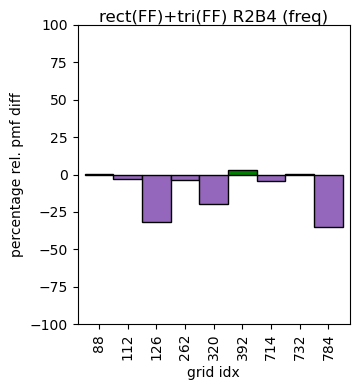

In [11]:
print(idx_name)
print(pmf_diff)
print(np.array(pmf_diff).mean() * 100.0)

pmf_percent_diff = 100.0 * np.array(pmf_diff)
data = pd.DataFrame(pmf_percent_diff,index=idx_name, columns=['values'])
fig, (ax1) = plt.subplots(1,1,sharex=True,
                         figsize=(3.7,4.0))

data['values'].plot(kind='bar', width=1.0, edgecolor='black', color=(data['values'] > 0).map({True: 'g', False: 'C4'}))

plt.xlabel("grid idx")
plt.ylabel("percentage rel. pmf diff")

cs1 = "rect(FF)+tri(FF)\nuw_pmf_freqs_(large pmf 10p cutoff)"
cs2 = "rect(FF)+tri(FF)\nfreqs_(10p cutoff)"
cs3 = "tri(FF)+tri(FF)\nuw_pmf_freqs_(25 ampls)"
cs4 = "tri(FF)+tri(FF)\nfreqs"
cs5 = "tri(FF)+tri(FF)\niteration"
cs_none = "finer (100 FFT dof)"
cs_title = "approx. R2B4 (100 FFT dof)"
cs_dd = "rect(FF)+tri(FF) R2B4 (freq)"

title = cs_dd
plt.title(title, fontsize=12, pad=-10)
plt.ylim([-100,100])
plt.tight_layout()
plt.savefig('./study/'+title.replace('\n','_')+'_'+str(np.random.randint(1000))+'.png')
plt.show()

# Rect FF + Tri FF

In [22]:
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(physics)
# Setup the Fourier parameters and object.
nhi = 24
nhj = 24

fobj = fourier.f_trans(nhi,nhj)

idx = 82

# For each triangle...
# for idx in range(len(tri.simplices)):

cell.mask = mask_tmp

all_cells = np.zeros(2, dtype='object')
idx_name = []
# for cnt, idx in enumerate(range(0,2)):
# for cnt, idx in enumerate(range(2,4)):
# for cnt, idx in enumerate(range(4,6)):
# for cnt, idx in enumerate(range(6,8)):
# for cnt, idx in enumerate(range(8,10)):
# for cnt, idx in enumerate(range(10,12)):
# for cnt, idx in enumerate(range(12,14)):
# for cnt, idx in enumerate(range(14,16)):
# for cnt, idx in enumerate(range(16,18)):
# for cnt, idx in enumerate(range(18,20)):
# for cnt, idx in enumerate(range(20,22)):
# for cnt, idx in enumerate(range(58,60)):         # overestimation
# for cnt, idx in enumerate(range(48,50)):
# for cnt, idx in enumerate(range(88,90)):        # underestimation
# for cnt, idx in enumerate(range(42,44)):
# for cnt, idx in enumerate(range(44,46)):
# for cnt, idx in enumerate(range(54,56)):
# for cnt, idx in enumerate(range(82,84)):
for cnt, idx in enumerate(range(90,92)):
    if cnt == 0:
        cell = var.topo_cell()

        print("computing idx:", idx)
        simplex_lat = circ_tri_lat_verts[idx]
        simplex_lon = circ_tri_lon_verts[idx]

        polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

        init_poly = mask_wrapper(polygon)
        cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')

        mask_tmp = np.copy(cell.mask)
        get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo, rect=True)

        # do fourier...
        fobj.do_full(cell)
        am, data_recons = lin_reg.do(fobj, cell, lmbda = 0.0)

        dat_2D = reconstruction.recon_2D(data_recons, cell)


        fobj.get_freq_grid(am)
        freqs = np.abs(fobj.ampls)

        analysis = var.analysis()
        analysis.get_attrs(fobj, freqs)

        fs = (8.5,4.2)
        fig, axs = plt.subplots(1,2, figsize=fs)
        fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
        axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
        axs[1] = fig_obj.freq_panel(axs[1], freqs)
        plt.tight_layout()
        plt.savefig('output/T%i.pdf' %idx)
        plt.show()

        # print(freqs)
        ideal = physics.ideal_pmf(U=10.0, V=1.0)

        uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)
        # uw_pmf_freqs = analysis.grid_kk_ll(fobj, uw_pmf_freqs)

        fq_cpy = np.copy(freqs)
        # fq_cpy = uw_pmf_freqs
        # total_power = fq_cpy.sum()
        total_power = freqs.sum()

        ref_power = np.abs(np.fft.rfft2(cell.topo - cell.topo.mean())) / cell.topo.size
        ref_power = ref_power.sum()
        print("ref power =", ref_power)
        print("total power =", total_power)
        print("reg max, reg min =", fq_cpy.max(), fq_cpy.min())
        print("sum(fq_cpy) =", fq_cpy.sum())

        indices = []
        max_ampls = []

        if cnt == 0:
            nts = 30
        elif cnt == 1:
            nts = 8

        for ii in range(50):
            max_idx = np.unravel_index(fq_cpy.argmax(), fq_cpy.shape)
            indices.append(max_idx)
            max_ampls.append(freqs[max_idx])
            max_val = fq_cpy[max_idx]
            fq_cpy[max_idx] = 0.0

            # if (sum(max_ampls) >= 0.1 * ref_power):
                # break
            if (sum(max_ampls) >= 1.0 * total_power):
                break
            # if sum(max_ampls) >= (total_power / 44000) * 44000:
                # break
            # if max_val < 0.01 * total_power:
            if max_ampls[-1] <= 0.1 * max_ampls[0]:
                break
        
    #####################################

    cell = var.topo_cell()

    print("computing idx:", idx)
    simplex_lat = circ_tri_lat_verts[idx]
    simplex_lon = circ_tri_lon_verts[idx]

    polygon = np.array([list(item) for item in zip(simplex_lon, simplex_lat)])

    init_poly = mask_wrapper(polygon)
    cell.mask = np.array([init_poly(elem) for elem in lat_lon_mgrid]).reshape(topo.lon_grid.shape[0],topo.lon_grid.shape[1]).astype('bool_')
    # initialise cell object         
    get_lat_lon_segments(tri_lat_verts[idx], tri_lon_verts[idx], cell, topo, rect=False)
    
    print(max_ampls, len(max_ampls), sum(max_ampls))
    k_idxs = [pair[1] for pair in indices]
    l_idxs = [pair[0] for pair in indices]
    
    fobj.set_kls(k_idxs, l_idxs)
    fobj.do_full(cell)

    am, data_recons = lin_reg.do(fobj, cell, lmbda = 1e-6)

    fobj.get_freq_grid(am)
    dat_2D = reconstruction.recon_2D(data_recons, cell)

    freqs = np.abs(fobj.ampls)
    
    print("\n double reg. sum: ",freqs.sum())
    
    analysis = var.analysis()
    analysis.get_attrs(fobj, freqs)
    analysis.recon = dat_2D
    
    cell.analysis = analysis
    
    topo_tri = cell.topo * cell.mask
    topo_tri -= topo_tri.mean()
    
    all_cells[cnt] = cell

    if cnt == 0:
        v_extent = [dat_2D.min(), dat_2D.max()]
    
    fs = (8.5,4.2)
    fig, axs = plt.subplots(1,2, figsize=fs)
    fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
    axs[0] = fig_obj.phys_panel(axs[0], dat_2D, title='T%i: Reconstruction' %idx, xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()], v_extent=v_extent)
    axs[1] = fig_obj.freq_panel(axs[1], freqs)
    plt.tight_layout()
    plt.savefig('output/T%i.pdf' %idx)
    plt.show()
    
    idx_name.append(idx)
    
fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, cell.topo, title='GMTED2010 orography', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/orig_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

computing idx: 90


NameError: name 'circ_tri_lat_verts' is not defined

(288, 187)
10.0 0.1
0.013950212343954587
0.02076699693802345 0.04687996618090568 0.03382348155946457


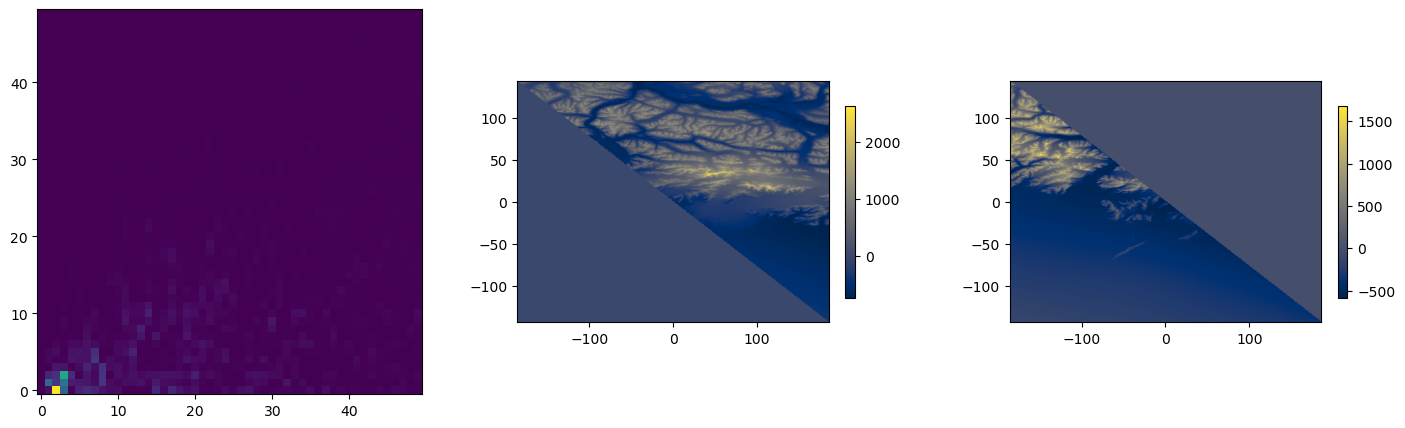

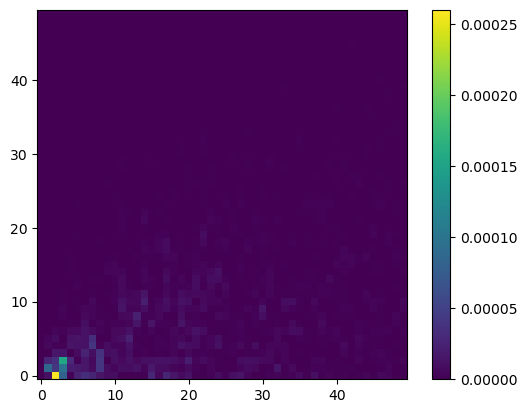

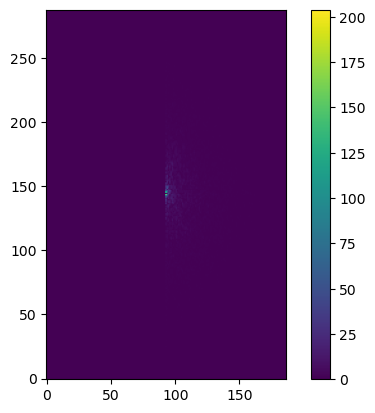

3584.5310031986096


In [183]:
importlib.reload(physics)

cell0 = all_cells[0]
cell1 = all_cells[1]

topo_blur = gaussian_filter(cell0.topo - cell0.topo.mean(), sigma=0)
# topo_blur = cell.topo - cell.topo.mean()

# topo_test = cell0.analysis.recon + cell1.analysis.recon
# ampls = np.fft.fft2(topo_test)

ampls = np.fft.rfft2(cell.topo - cell.topo.mean())
# ampls = np.fft.fft2(topo_blur)
ampls = np.abs(ampls) / cell.topo.size

print(ampls.shape)
ampls = ampls#.reshape(-1,)[1:]

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = np.fft.rfftfreq((ampls.shape[1] * 2) - 1, d=1.0).reshape(-1,1)
lls = np.fft.fftfreq((ampls.shape[0]), d=1.0).reshape(1,-1)
# kks = np.fft.fftfreq((ampls.shape[1]), d=1.0).reshape(-1,1)
# lls = np.fft.fftfreq((ampls.shape[0]), d=1.0).reshape(1,-1)
# print(lls)
kkg, llg = np.meshgrid(kks, lls)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = 2.0 * ampls
analysis.kks = kkg#.reshape(-1,)#[1:] #/ kkg.size
analysis.lls = llg#.reshape(-1,)#[1:] #/ llg.size

ideal = physics.ideal_pmf(U=10.0, V=0.1)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis, summed=False)
# uw_ref[0,0] = 0.0
print(uw_ref.sum())

uw0 = ideal.compute_uw_pmf(all_cells[0].analysis) #* all_cells[0].topo_m.size
uw1 = ideal.compute_uw_pmf(all_cells[1].analysis) #* all_cells[1].topo_m.size

uw01 = 0.5 * (uw0 + uw1) #/ all_cells[0].topo.size
print(uw0, uw1, uw01)

fs = (18,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
# axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[0].imshow(uw_ref[:50,:50], origin='lower')
axs[1] = fig_obj.phys_panel(axs[1], cell.topo * cell0.mask)
axs[2] = fig_obj.phys_panel(axs[2], cell.topo * cell1.mask)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()
plt.imshow((uw_ref[:50,:50]), origin='lower')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.fft.fftshift(ampls), origin='lower')
plt.colorbar()
plt.show()

print(freqs.sum())

[6143820.78507951 6143820.78507951 3171245.84462749 3171245.84462749
 1791681.46206235 1791681.46206235 1694513.67587421 1694513.67587421
 1256097.17170356 1256097.17170356]


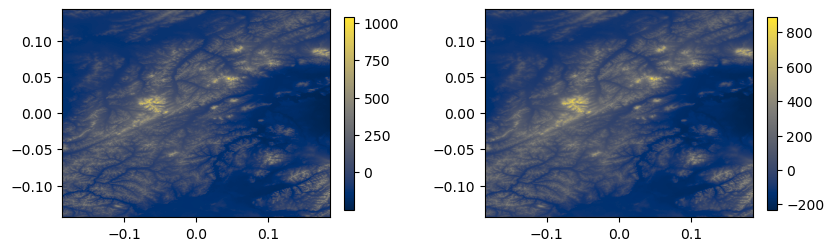

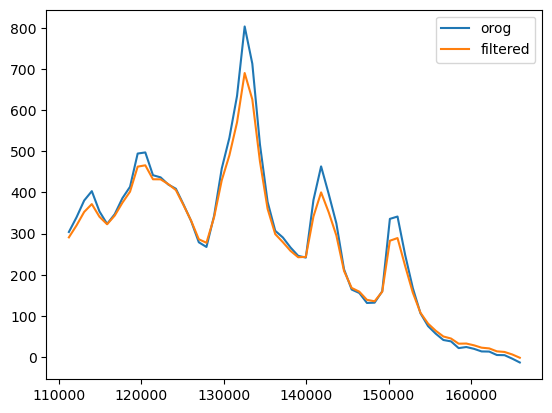

In [121]:
ampls = np.fft.fft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.fftfreq(ampls.shape[1], d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

# print(kls.shape)
ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.ifft2(ampls).real

amtrunc = np.copy(ampls)
amtrunc = np.abs(amtrunc)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1][:10]
print(amtrunc)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 120, 180
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx], label='orog')
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx], label='filtered')
plt.legend()
plt.show()

In [136]:
test = np.fft.fft2(topo_blur)
test=test.reshape(-1,)
print((np.abs(test)**2)[:25])
print((test * np.conj(test))[:25])

[8.27180613e-19 1.07169190e+13 4.47574325e+10 2.27615822e+11
 2.52563889e+11 1.11337568e+11 1.82325374e+11 3.05554825e+10
 8.12200612e+07 5.93927269e+10 1.98447706e+09 6.41192095e+09
 5.50445873e+09 2.56420920e+10 3.70774687e+07 1.18395537e+10
 2.55797572e+09 1.81732761e+10 1.52000283e+10 6.11877207e+08
 6.83045467e+08 5.72746045e+08 3.28774544e+09 1.00101939e+09
 5.05963178e+08]
[8.27180613e-19+0.j 1.07169190e+13+0.j 4.47574325e+10+0.j
 2.27615822e+11+0.j 2.52563889e+11+0.j 1.11337568e+11+0.j
 1.82325374e+11+0.j 3.05554825e+10+0.j 8.12200612e+07+0.j
 5.93927269e+10+0.j 1.98447706e+09+0.j 6.41192095e+09+0.j
 5.50445873e+09+0.j 2.56420920e+10+0.j 3.70774687e+07+0.j
 1.18395537e+10+0.j 2.55797572e+09+0.j 1.81732761e+10+0.j
 1.52000283e+10+0.j 6.11877207e+08+0.j 6.83045467e+08+0.j
 5.72746045e+08+0.j 3.28774544e+09+0.j 1.00101939e+09+0.j
 5.05963178e+08+0.j]


[2.18540753e+07 2.18540753e+07 6.44235576e+06 ... 7.02704028e+01
 6.90377682e+01 5.41331246e-09]
(288, 187)
(1, 187) (288, 1)
10.0 1.0
0.16502996606468595


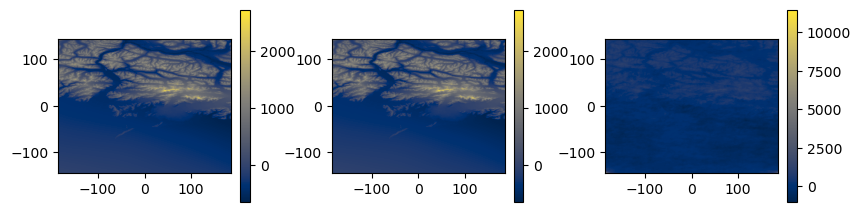

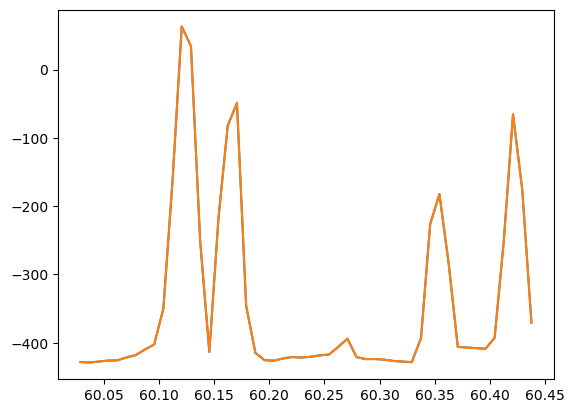

In [162]:
### ampls = np.fft.rfft2(topo_blur)
# ampls = np.abs(ampls) / cell.topo.size
Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1, d=0.08491180322081891).reshape(1,-1)
Ls = np.fft.fftfreq(ampls.shape[0], d=0.08491180322081891).reshape(-1,1)
# print(Ks.shape, Ls.shape)
# print(Ks)

kls = (Ks**2 + Ls**2)**0.5

ampls = np.fft.rfft2(topo_blur)

# print(kls.shape)
# ampls *= np.exp(-(kls / (2.0 * np.pi * 5))**0.5)
inverse = np.fft.irfft2(ampls).real

amtrunc = np.copy(ampls)
# amtrunc = np.abs(amtrunc)
amtrunc = np.sort(np.abs(amtrunc).reshape(-1,))[::-1]#[:10]
print(amtrunc)
cutoff = amtrunc[-1]

ampls_cpy = np.copy(ampls)
ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

inverse_trunc = np.fft.irfft2(ampls_cpy).real

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

# Ks = np.fft.rfftfreq((ampls.shape[1] * 2)-1,).reshape(1,-1)
# Ls = np.fft.fftfreq(ampls.shape[0],).reshape(-1,1)

sz = cell.topo.size
kks = Ks
lls = Ls

kkg, llg = np.meshgrid(kks, lls)

print(ampls.shape)
print(kks.shape, lls.shape)

analysis = var.analysis()
analysis.wlat = wlat
analysis.wlon = wlon
analysis.ampls = 2.0 * np.abs(ampls_cpy[np.where(ampls > cutoff)]) / sz
analysis.kks = kkg[np.where(ampls > cutoff)]
analysis.lls = llg[np.where(ampls > cutoff)]

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_ref = ideal.compute_uw_pmf(analysis)

print(uw_ref)

fs = (10,5)
fig, axs = plt.subplots(1,3, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
# axs[0] = fig_obj.phys_panel(axs[0], cell.topo)
axs[0] = fig_obj.phys_panel(axs[0], topo_blur)
axs[1] = fig_obj.phys_panel(axs[1], inverse)
axs[2] = fig_obj.phys_panel(axs[2], inverse_trunc)
# axs[2] = fig_obj.freq_panel(axs[2], np.fft.fftshift(freqs), nhi=cell.topo.shape[1], nhj=cell.topo.shape[0])
plt.show()

plt.figure()

sidx, eidx = 100, 150
plt.plot(cell.lat[sidx:eidx], topo_blur[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.plot(cell.lat[sidx:eidx],inverse[int(topo_blur.shape[0]/2)][sidx:eidx])
plt.show()

In [15]:
import pandas as pd

XX = pd.Series([uw_ref,uw_50m,uw01],index=['full discrete\nfast-Fourier\ntransform','50-mode\nspectral\nrepresentation','unstructured\nspectral\napprox.'])
fig, (ax1) = plt.subplots(1,1,sharex=True,
                         figsize=(3.7,4.0))
# ax1.spines['bottom'].set_visible(False)
# ax1.tick_params(axis='x',which='both',bottom=False)
# ax2.spines['top'].set_visible(False)

bs = 700
ts = 37500

# ax2.set_ylim(0,bs)
ax1.set_ylim(0,0.04)

bars1 = ax1.bar(XX.index, XX.values, color=('C4', 'C5', 'C6'))
# bars2 = ax2.bar(XX.index, XX.values, color=('C0', 'C1', 'C2', 'r'))
ax1.bar_label(bars1, padding=3)
ax1.set_yticks(np.arange(0.0,0.05,0.01,))
# ax2.bar_label(bars2, padding=3)

# ax2.axhline(np.around(ref_sum, 2), ls='--', c='k')

# for tick in ax2.get_xticklabels():
    # tick.set_rotation(0)
# d = .015  
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)      
# ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
# kwargs.update(transform=ax2.transAxes)  
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# for b1, b2 in zip(bars1, bars2):
#     posx = b2.get_x() + b2.get_width()/2.
#     if b2.get_height() > bs:
#         ax2.plot((posx-3*d, posx+3*d), (1 - d, 1 + d), color='k', clip_on=False,
#                  transform=ax2.get_xaxis_transform())
#     if b1.get_height() > ts:
#         ax1.plot((posx-3*d, posx+3*d), (- d, + d), color='k', clip_on=False,
#                  transform=ax1.get_xaxis_transform())
        
plt.title("pseudo-momentum fluxes ($\overline{u^\prime w^\prime}$)", fontsize=12, pad=-10)
plt.tight_layout()
plt.savefig('output/pmf_T%i_T%i_large.pdf' %(idx_name[0], idx_name[1]))
plt.show()

NameError: name 'uw_50m' is not defined

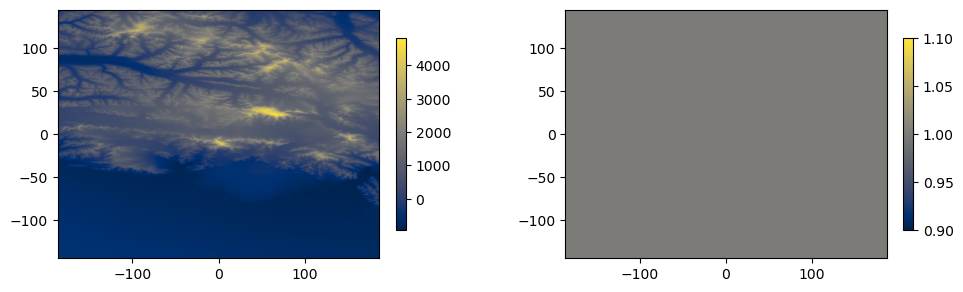

(288, 372)


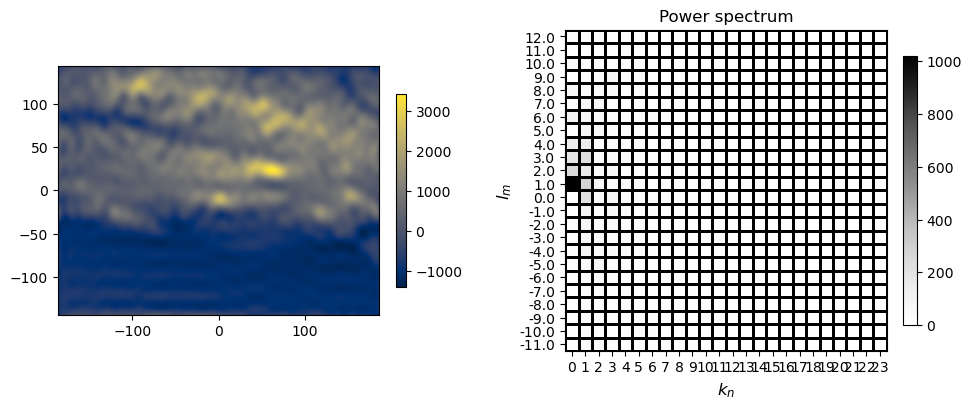

10427.249944107567
0.017737929376466885
(564,) (564,) (564,)
10.0 1.0
uw_50m = 0.01773792937646688


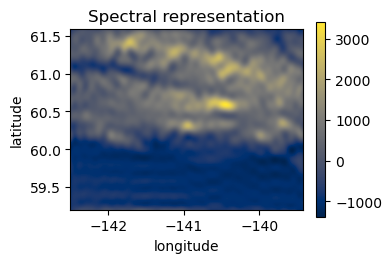

In [24]:
nhi = 24
nhj = 24

fobj = fourier.f_trans(nhi,nhj)

cell0 = all_cells[0]

cell0.mask[...] = 1

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], cell0.topo)
axs[1] = fig_obj.phys_panel(axs[1], cell0.mask)
plt.show()

cell0.topo_m = cell0.topo[cell0.mask]
cell0.topo_m -= cell0.topo_m.mean()
cell0.lat_m = cell0.lat_grid[cell0.mask]
cell0.lon_m = cell0.lon_grid[cell0.mask]

fobj.do_full(cell0)
am, data_recons = lin_reg.do(fobj, cell0, lmbda = 0.0)

print(cell.topo.shape)

dat_2D = reconstruction.recon_2D(data_recons, cell0)

fobj.get_freq_grid(am)
freqs = np.abs(fobj.ampls)

cell0.analysis.get_attrs(fobj, freqs)

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()

print(freqs.sum())

#################################

analysis = var.analysis()
analysis.get_attrs(fobj, freqs)

ideal = physics.ideal_pmf(U=10.0, V=1.0)

uw_pmf_freqs = ideal.compute_uw_pmf(analysis, summed=False)

print(uw_pmf_freqs.sum())

# ampls = fobj.ampls
# amtrunc = np.copy(freqs)
amtrunc = np.copy(uw_pmf_freqs)
amtrunc = np.sort(amtrunc.reshape(-1,))[::-1]#[:10]
# print(amtrunc)
cutoff = amtrunc[50]

ampls_cpy = np.copy(fobj.ampls)
# ampls_cpy[np.where(ampls_cpy <= cutoff)] = 0.0

# print(cutoff)
# print(len(freqs[np.where(freqs > cutoff)]))

wlat = np.diff(cell.lat).max()
wlon = np.diff(cell.lon).max()

sz = cell.topo.size
kks = fobj.m_i / (fobj.Ni)
lls = fobj.m_j / (fobj.Nj)

kkg, llg = np.meshgrid(kks, lls)

cell0.analysis.ampls = np.abs(ampls_cpy[np.where(freqs > cutoff)])
cell0.analysis.kks = kkg[np.where(freqs > cutoff)]
cell0.analysis.lls = llg[np.where(freqs > cutoff)]

ddd = cell0.analysis
print(ddd.kks.shape, ddd.lls.shape, ddd.ampls.shape)

ideal = physics.ideal_pmf(U=10.0, V=1.0)

print(ideal.U, ideal.V)

uw_50m = ideal.compute_uw_pmf(cell0.analysis)

print("uw_50m =", uw_50m)

fs = (4.0,4.2)
fig, axs = plt.subplots(1,1, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs = fig_obj.phys_panel(axs, dat_2D, title='Spectral representation', xlabel='longitude', ylabel='latitude', extent=[cell.lon.min(), cell.lon.max(), cell.lat.min(), cell.lat.max()])
plt.tight_layout()
plt.savefig('output/spec_rep_topo_T%i_T%i.pdf' %(idx_name[0], idx_name[1]))
plt.show()

In [16]:
print(fobj.Nj)
print(fobj.I)

print(fobj.Nj)
print(fobj.J)

287
[369 368 369 ... 367 368 369]
287
[  0   1   1 ... 286 286 286]


In [17]:
fft_ampls = np.fft.rfft2(cell0.topo - cell0.topo.mean())
# fft_ampls = np.fft.rfft2(topo_blur)
fft_ampls = np.abs(fft_ampls) / cell0.topo.size
fft_freqs = np.copy(fft_ampls)

# sz_fft = fft_ampls.size
# fft_add_ampls = fft_ampls.reshape(-1,)[1:int(sz_fft/2+1)] + fft_ampls.reshape(-1,)[int(sz_fft/2):][::-1]
# fft_add_ampls = np.append(fft_ampls[0], fft_add_ampls)

# print(np.sort(fft_add_ampls)[::-1])

print(fft_ampls.max())
print(freqs.max())

print(fft_ampls.sum())
print(freqs.sum())

ampls_sorted = np.sort(fft_ampls.reshape(-1,))[::-1][:288]
# print(ampls_sorted)
# ampls_summed = ampls_sorted[1::2] + ampls_sorted[:-1:2]

# print(ampls_summed)

print(2.0 * ampls_sorted[:26])

print(np.sort(freqs.reshape(-1,))[::-1][:26])
print(ampls_summed.sum())
print(np.sort(freqs.reshape(-1,))[::-1].sum())


# print(np.sort(fft_ampls.reshape(-1,))[::-1].sum())

# print(np.sort(freqs.reshape(-1,))[::-1].sum())


149.14041752777854
258.6477791826307
23728.18243165363
1913.943769035321
[298.28083506 241.8574983  185.10780854 173.04213087 173.04213087
 105.78408871 101.14385293  99.66945     89.34850478  77.31654614
  75.36632766  72.22061538  71.68840896  70.74420449  70.74420449
  68.66301156  64.07276982  62.61341939  60.1193949   58.07651112
  57.94426567  55.52314077  53.99492915  53.45126041  51.88971584
  50.79836106]
[258.64777918 172.49286337 146.87016938 108.91047713  97.70175944
  96.83736757  95.32183593  93.22270269  81.16603783  80.92415492
  72.33638222  67.29088202  58.67386704  57.02706062  53.58653191
  51.30618277  47.40157979  43.89696227  40.27449421  38.33046238
  37.66262367  34.27839466  33.18129301  29.29063414  17.31127089
   0.        ]


NameError: name 'ampls_summed' is not defined

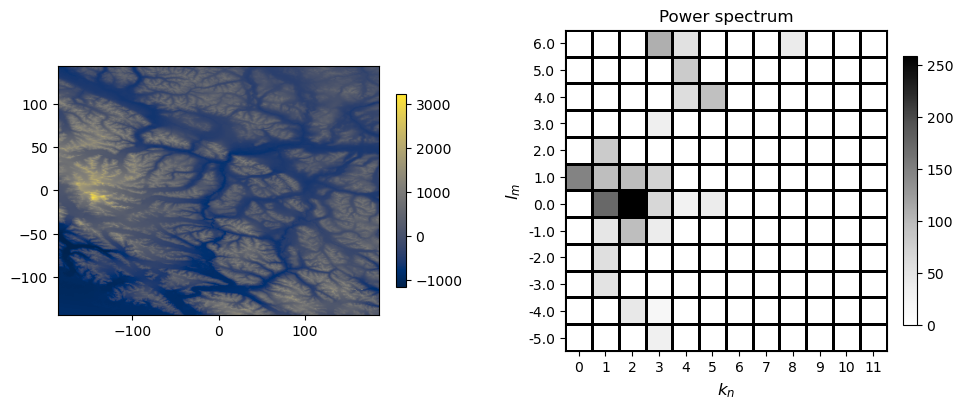

In [18]:
fft_ampls = np.fft.fft2(cell0.topo - cell0.topo.mean())

physical = np.fft.ifft2(fft_ampls).real

fs = (12,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, fobj.nhar_i, fobj.nhar_j)
axs[0] = fig_obj.phys_panel(axs[0], physical)
axs[1] = fig_obj.freq_panel(axs[1], freqs)
plt.show()



AttributeError: 'topo_cell' object has no attribute 'I'